# Compare the performance of several pre-processing pipelines in terms of motion correction as measured by the root mean square of the temporal derivative of the post-processed fMRI signal (DVARS)

### Spurious but systematic correlations in functional connectivity MRI networks arise from subject motion - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3254728/

### Comparing resting state fMRI de-noising approaches using multi- and single-echo acquisitions (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0173289)  
### An evaluation of the efficacy, reliability, and sensitivity of motion correction strategies for resting-state functional MRI (https://www.sciencedirect.com/science/article/pii/S1053811917310972)

In [1]:
import glob
import os
import sys

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from scipy import stats
from scipy.stats import wilcoxon

from statsmodels.stats.multitest import multipletests
from statannot import add_stat_annotation
# from statannotations.Annotator import Annotator

import itertools

In [2]:
# First, check if the ASC and TD groups differ significantly in terms of age, IQ 
# and in-scanner movement (i.e. framewise displacement - FD)
# Participant list : 
# M005B, M007A, M008A, M010A, M013B, M014A, M015C, M016C, M020B
# M105B, M106C, M109C, M110A, M111B, M114A, M115C, M121A

In [ ]:
# To check for normality of data
def check_norm(data):
    # Visualise first
    plt.hist(data
             ,bins = 10
            )
    plt.show()
    
    k2, p = stats.normaltest(data)
    alpha = 0.05

    print('P-value = ' + '{0:.10f}'.format(p))

    # null hypothesis: x comes from a normal distribution
    if p < alpha:
        print("The null hypothesis can be rejected. The sample is NOT normally distributed.")
        return False
    else:
        print("The null hypothesis cannot be rejected. The sample is normally distributed.")
        return True

In [ ]:
# Check for equality of variances
def calc_var_equal(d1, d2):
    v1, v2 = np.var(d1), np.var(d2)
    if (v1 / v2) or (v2 / v1) >= 4:
        print("Equality = False")
        return False
    else:
        print("Equality = True")
        return True

In [ ]:
# Test for significant group differences
def test_sign_diff(d1, norm_d1, d2, norm_d2, var_equal):
    if norm_d1 == True and norm_d2 == True:
        if var_equal == True:
            print(stats.ttest_ind(a=d1, b=d2, equal_var=True))
        # https://www.statology.org/determine-equal-or-unequal-variance/
        else:
            print(stats.ttest_ind(a=d1, b=d2, equal_var=False))
    else:
        #https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html
        u, prob = stats.mannwhitneyu(d1, d2)
        print("u = {:g}".format(u))
        print("prob = {:g}".format(prob))
        # to get two-sided p-value:
        two_sided_prob = 2 * prob
        print("P-value = " + str(two_sided_prob))

In [ ]:
# Run
def covariate_check(factor):
    # Get data for each group
    td_df = factor.iloc[:9,1]
    asc_df = factor.iloc[11:19,1]
    
    # Check normality of each subsample
    norm_td = check_norm(td_df)
    norm_asc = check_norm(asc_df)
    
    # Check equality of variances
    var_equal = calc_var_equal(td_df, asc_df)
    
    # Test if the group differences are signifcant
    test_sign_diff(td_df, norm_td, asc_df, norm_asc, var_equal)

In [7]:
# Load framewise displacement (FD) data
fd_df = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/mean_fd_split.xlsx', sheet_name='asc_td_p', engine='openpyxl')

In [9]:
# Load age data
age_df = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/ARB_cov_split.xlsx', sheet_name='age_asc_td_p', engine='openpyxl')

In [16]:
# Load IQ data
iq_df = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/ARB_cov_split.xlsx', sheet_name='iq_asc_td_p', engine='openpyxl')

In [ ]:
# Check FD
covariate_check(fd_df)

In [ ]:
# Check Age
covariate_check(age_df)

In [ ]:
# Check IQ
covariate_check(iq_df)

In [2]:
# Create a list of DVARS values for each pipeline
pipeline_list = []
for n in range(12):
        # Get a pipeline
        pipeline = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/ARB_QC.xlsx', sheet_name=n, engine='openpyxl')
        
        pipeline_mean = pipeline.mean()
        
        ## # Stack all values into a 1D vector
        #stacked_pipeline = pipeline.stack()
        
        # Add to the list
        pipeline_list.append(pipeline_mean)

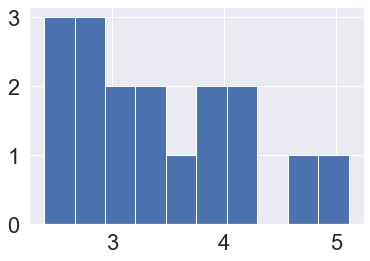

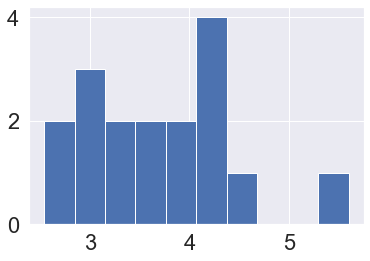

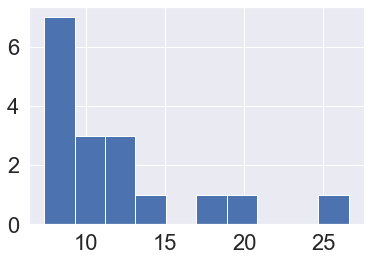

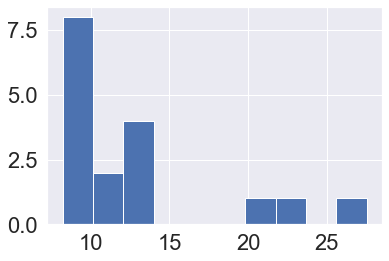

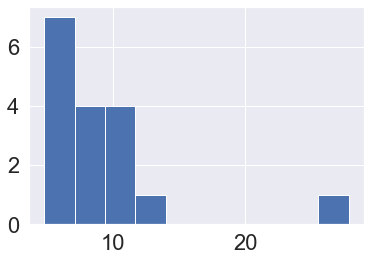

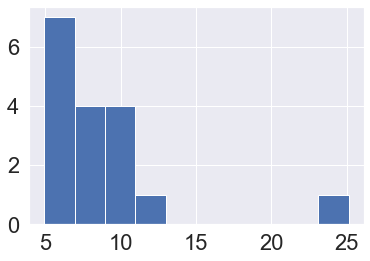

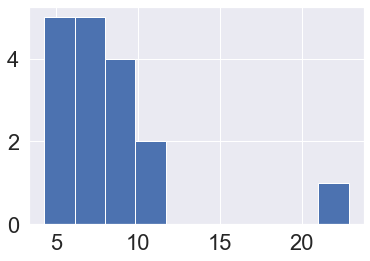

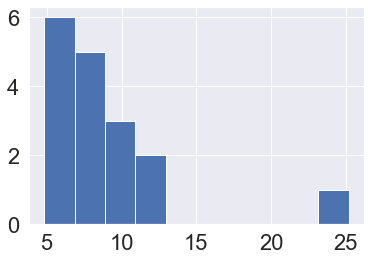

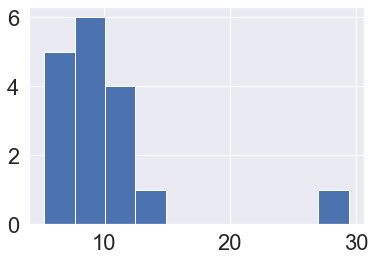

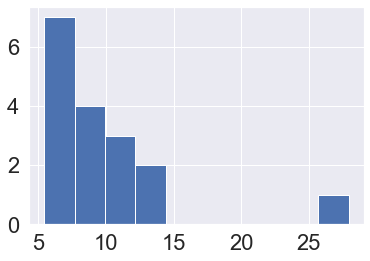

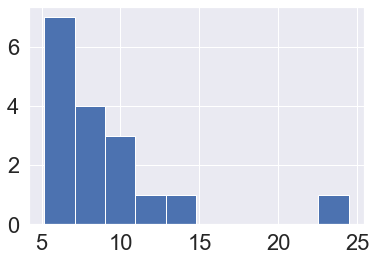

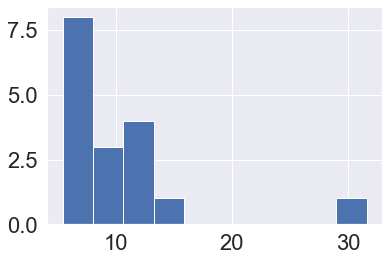

In [4]:
# Check distributions
for n in range(12):
    plt.hist(pipeline_list[n]#, bins = 20
            )
    plt.show()

In [3]:
pipeline_names = [
 '1-echo baseline',
 '1-echo + SDC',
 '3-echo',
 '3-echo + SDC',
 '3-echo + T2s',
 '3-echo + T2s + SDC',
 '4-echo',
 '4-echo + SDC',
 '4-echo + T2s',
 '4-echo + T2s + SDC',
 '3-echo ME-ICA', 
 '4-echo ME-ICA']

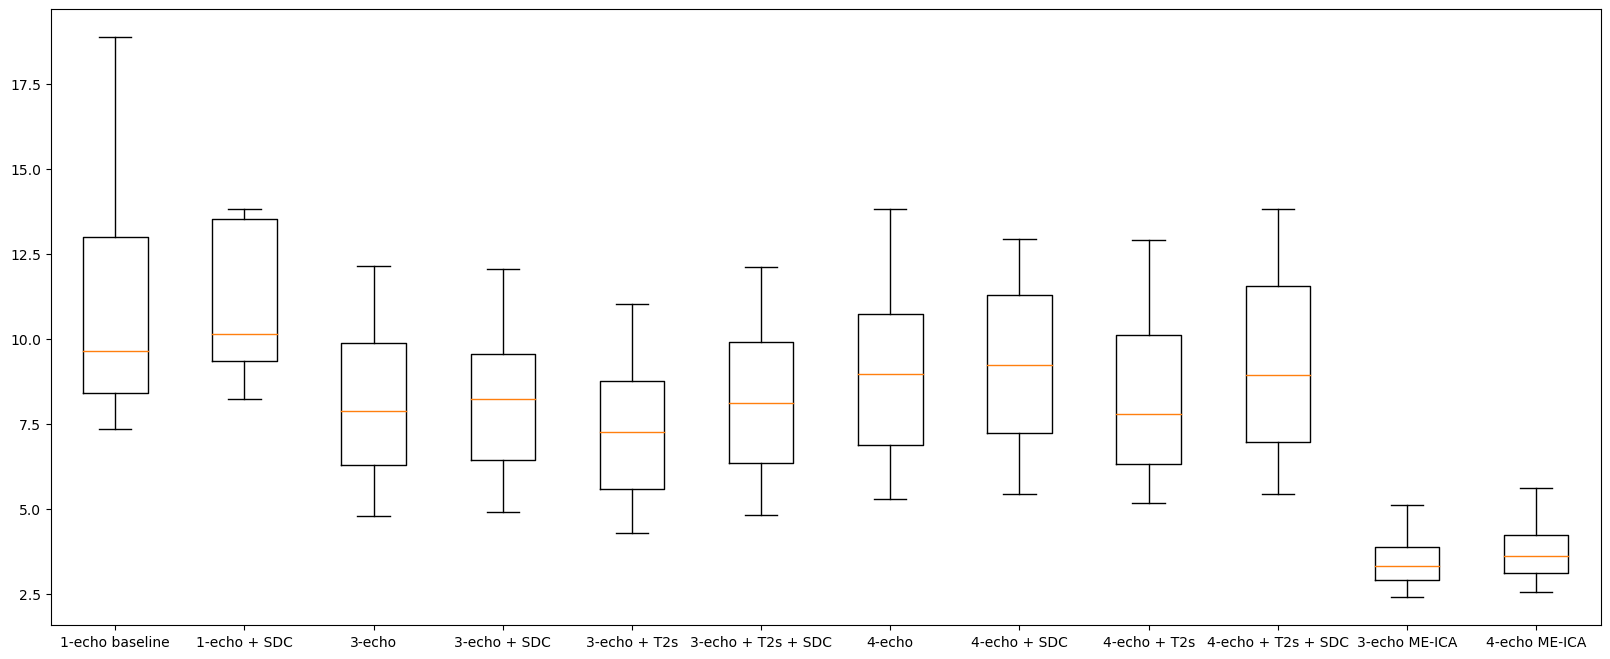

In [4]:
# Create a simple DVARS boxplot
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots(figsize=(20,8))
dvars_figure = ax.boxplot(pipeline_list, 
                          #notch=True, 
                          bootstrap=5000, 
                          showfliers=False)
ax.set_xticklabels(pipeline_names)
#plt.show(dvars_figure)
plt.savefig("dvars.png")

In [5]:
# Convert the list of Pandas Series objects into a Pandas DataFrame object
pipeline_df = pd.concat(pipeline_list, axis=1)
pipeline_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,8.013653,8.509865,5.954832,6.133682,5.194714,5.985651,6.538732,6.620330,5.940531,6.792080,2.668959,2.854719
0.1,12.471134,12.455843,7.888494,8.228786,7.256034,8.122071,8.956408,9.220009,7.792662,8.943897,3.313261,3.615924
0.2,8.952429,9.528632,5.914847,5.992293,5.131589,5.589490,6.260594,6.720811,5.502206,6.574496,2.538471,2.573757
0.3,18.879519,20.203082,10.094018,9.561829,8.532870,10.136182,10.741296,11.302235,10.473412,11.563176,3.650608,4.243820
0.4,7.359915,8.224282,5.944278,6.000815,5.104546,6.262449,6.663245,6.717877,5.921671,6.621678,3.140865,3.608940
0.5,8.412696,9.340946,6.443665,6.443599,6.242027,6.358249,7.794377,7.469472,6.797657,7.665483,3.389626,3.375679
0.6,9.406554,10.156535,6.660807,6.848240,6.293453,7.043914,7.750688,7.475465,6.859715,7.252450,2.893514,3.281492
0.7,20.307169,22.113706,10.926518,10.714843,9.942067,10.974497,12.317362,12.748072,11.115284,12.943254,4.063908,4.371888
0.8,14.025400,13.810573,12.139374,12.059606,11.020586,12.106397,13.820858,12.948770,12.911030,13.835455,2.971192,4.106362
0.9,10.185870,10.429547,9.878310,9.842127,9.635537,9.896267,10.337590,11.292864,9.455420,10.850279,3.875691,4.020410


In [6]:
# Rename columns so that they are labelled by the pipeline names
pipeline_df.columns = pipeline_names

In [7]:
# Visualise the updated dataframe
pipeline_df

,1-echo baseline,1-echo + SDC,3-echo,3-echo + SDC,3-echo + T2s,3-echo + T2s + SDC,4-echo,4-echo + SDC,4-echo + T2s,4-echo + T2s + SDC,3-echo ME-ICA,4-echo ME-ICA
0,8.013653,8.509865,5.954832,6.133682,5.194714,5.985651,6.538732,6.620330,5.940531,6.792080,2.668959,2.854719
0.1,12.471134,12.455843,7.888494,8.228786,7.256034,8.122071,8.956408,9.220009,7.792662,8.943897,3.313261,3.615924
0.2,8.952429,9.528632,5.914847,5.992293,5.131589,5.589490,6.260594,6.720811,5.502206,6.574496,2.538471,2.573757
0.3,18.879519,20.203082,10.094018,9.561829,8.532870,10.136182,10.741296,11.302235,10.473412,11.563176,3.650608,4.243820
0.4,7.359915,8.224282,5.944278,6.000815,5.104546,6.262449,6.663245,6.717877,5.921671,6.621678,3.140865,3.608940
0.5,8.412696,9.340946,6.443665,6.443599,6.242027,6.358249,7.794377,7.469472,6.797657,7.665483,3.389626,3.375679
0.6,9.406554,10.156535,6.660807,6.848240,6.293453,7.043914,7.750688,7.475465,6.859715,7.252450,2.893514,3.281492
0.7,20.307169,22.113706,10.926518,10.714843,9.942067,10.974497,12.317362,12.748072,11.115284,12.943254,4.063908,4.371888
0.8,14.025400,13.810573,12.139374,12.059606,11.020586,12.106397,13.820858,12.948770,12.911030,13.835455,2.971192,4.106362
0.9,10.185870,10.429547,9.878310,9.842127,9.635537,9.896267,10.337590,11.292864,9.455420,10.850279,3.875691,4.020410


In [8]:
# Show median DVARS for each pipeline
for i in range(pipeline_df.shape[1]):
    print('The min for ' + pipeline_df.columns[i] + ' is = ' + str(np.min(pipeline_df.iloc[:,i])) )

The min for 1-echo baseline is = 7.359915183246066
The min for 1-echo + SDC is = 8.224282408376968
The min for 3-echo is = 4.802129738219897
The min for 3-echo + SDC is = 4.915474345549739
The min for 3-echo + T2s is = 4.292291675392671
The min for 3-echo + T2s + SDC is = 4.831009267015706
The min for 4-echo is = 5.288160471204188
The min for 4-echo + SDC is = 5.436739738219898
The min for 4-echo + T2s is = 5.164307015706807
The min for 4-echo + T2s + SDC is = 5.435071884816752
The min for 3-echo ME-ICA is = 2.3952027225130896
The min for 4-echo ME-ICA is = 2.5376970680628275


In [9]:
# Show median DVARS for each pipeline
for i in range(pipeline_df.shape[1]):
    print('The median for ' + pipeline_df.columns[i] + ' is = ' + str(np.median(pipeline_df.iloc[:,i])) )

The median for 1-echo baseline is = 9.650608272251313
The median for 1-echo + SDC is = 10.156535497382201
The median for 3-echo is = 7.888494345549734
The median for 3-echo + SDC is = 8.228785811518318
The median for 3-echo + T2s is = 7.256034031413607
The median for 3-echo + T2s + SDC is = 8.12207057591622
The median for 4-echo is = 8.95640848167539
The median for 4-echo + SDC is = 9.220009109947647
The median for 4-echo + T2s is = 7.792661623036646
The median for 4-echo + T2s + SDC is = 8.943897225130888
The median for 3-echo ME-ICA is = 3.313260994764397
The median for 4-echo ME-ICA is = 3.615923560209425


In [10]:
# Show median DVARS for each pipeline
for i in range(pipeline_df.shape[1]):
    print('The max for ' + pipeline_df.columns[i] + ' is = ' + str(np.max(pipeline_df.iloc[:,i])) )

The max for 1-echo baseline is = 26.59212821989528
The max for 1-echo + SDC is = 27.526830366492145
The max for 3-echo is = 27.780960785340298
The max for 3-echo + SDC is = 25.117874240837704
The max for 3-echo + T2s is = 22.835839267015697
The max for 3-echo + T2s + SDC is = 25.16815591623035
The max for 4-echo is = 29.385685706806292
The max for 4-echo + SDC is = 27.913272513088994
The max for 4-echo + T2s is = 24.44719638743455
The max for 4-echo + T2s + SDC is = 31.6270889528796
The max for 3-echo ME-ICA is = 5.113745340314137
The max for 4-echo ME-ICA is = 5.601448481675396


In [11]:
# Create a list that contains all possible pairs of pipelines WITHOUT repetitions
combo_list = list(itertools.combinations(pipeline_names, 2))
print(combo_list)
# to see how many comparisons would be made:
print(len(combo_list))

[('1-echo baseline', '1-echo + SDC'), ('1-echo baseline', '3-echo'), ('1-echo baseline', '3-echo + SDC'), ('1-echo baseline', '3-echo + T2s'), ('1-echo baseline', '3-echo + T2s + SDC'), ('1-echo baseline', '4-echo'), ('1-echo baseline', '4-echo + SDC'), ('1-echo baseline', '4-echo + T2s'), ('1-echo baseline', '4-echo + T2s + SDC'), ('1-echo baseline', '3-echo ME-ICA'), ('1-echo baseline', '4-echo ME-ICA'), ('1-echo + SDC', '3-echo'), ('1-echo + SDC', '3-echo + SDC'), ('1-echo + SDC', '3-echo + T2s'), ('1-echo + SDC', '3-echo + T2s + SDC'), ('1-echo + SDC', '4-echo'), ('1-echo + SDC', '4-echo + SDC'), ('1-echo + SDC', '4-echo + T2s'), ('1-echo + SDC', '4-echo + T2s + SDC'), ('1-echo + SDC', '3-echo ME-ICA'), ('1-echo + SDC', '4-echo ME-ICA'), ('3-echo', '3-echo + SDC'), ('3-echo', '3-echo + T2s'), ('3-echo', '3-echo + T2s + SDC'), ('3-echo', '4-echo'), ('3-echo', '4-echo + SDC'), ('3-echo', '4-echo + T2s'), ('3-echo', '4-echo + T2s + SDC'), ('3-echo', '3-echo ME-ICA'), ('3-echo', '4-ech

In [12]:
# Use Wilcoxon test to obtain p-values and correct them using FDR
def wilcoxon_fdr(combo_list):
    uncorrected_p_vals = []
    # For each combo
    for n in range(len(combo_list)):
        combo_cont1 = combo_list[n][0]
        combo_cont2 = combo_list[n][1]
        # Perform Wilcoxon test 
        w, p = wilcoxon(pipeline_df.loc[:, combo_cont1].dropna(), pipeline_df.loc[:, combo_cont2].dropna())
        uncorrected_p_vals.append(p)
    
    # Correct the p-values using the FDR method
    # and more specifically, one of the newer variations (https://www.jstor.org/stable/20441303?seq=1)
    corrected_p_vals_extra = multipletests(uncorrected_p_vals, alpha=0.05, method='fdr_tsbky')
    corrected_p_vals = corrected_p_vals_extra[1]
    return uncorrected_p_vals, corrected_p_vals

In [13]:
uncorrected_p_vals, corrected_p_vals = wilcoxon_fdr(combo_list)

In [14]:
print("Values lower than 0.05 =", corrected_p_vals[corrected_p_vals < 0.05])
print("Their indices are ", np.nonzero(corrected_p_vals < 0.05))

Values lower than 0.05 = [2.01873779e-05 2.01873779e-05 3.20434570e-06 3.20434570e-06
 3.20434570e-06 9.39846039e-04 5.52749634e-04 3.20434570e-06
 1.54820492e-03 3.20434570e-06 3.20434570e-06 6.13598113e-06
 3.20434570e-06 3.20434570e-06 3.20434570e-06 1.19238633e-04
 7.06840964e-05 3.20434570e-06 9.39846039e-04 3.20434570e-06
 3.20434570e-06 9.01222229e-06 3.20434570e-06 3.20434570e-06
 3.31380941e-02 3.20434570e-06 3.20434570e-06 3.20434570e-06
 3.20434570e-06 3.20434570e-06 3.20434570e-06 3.20434570e-06
 3.20434570e-06 3.20434570e-06 3.20434570e-06 3.20434570e-06
 3.20434570e-06 6.13598113e-06 3.20434570e-06 3.20434570e-06
 3.20434570e-06 3.20434570e-06 3.20434570e-06 3.20434570e-06
 3.20434570e-06 3.20434570e-06 3.20434570e-06 8.23406351e-03
 3.20434570e-06 3.20434570e-06 3.20434570e-06 3.20434570e-06
 3.20434570e-06 3.20434570e-06 3.20434570e-06 3.20434570e-06
 3.20434570e-06 3.20434570e-06 5.52749634e-04]
Their indices are  (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,

In [15]:
print("Values higher than 0.05 =", corrected_p_vals[corrected_p_vals > 0.05])
print("Their indices are ", np.nonzero(corrected_p_vals > 0.05))

Values higher than 0.05 = [0.08215027 0.05557777 0.14318182 0.08550121 0.08215027 0.12410579
 0.0755041 ]
Their indices are  (array([21, 23, 31, 34, 47, 51, 57]),)


In [16]:
ns_list = list(np.nonzero(corrected_p_vals > 0.05))

3-echo v.s. 3-echo + SDC: Custom statistical test, P_val:8.215e-02
4-echo v.s. 4-echo + SDC: Custom statistical test, P_val:1.241e-01
3-echo + SDC v.s. 3-echo + T2s + SDC: Custom statistical test, P_val:1.432e-01
4-echo + SDC v.s. 4-echo + T2s + SDC: Custom statistical test, P_val:7.550e-02
3-echo v.s. 3-echo + T2s + SDC: Custom statistical test, P_val:5.558e-02
3-echo + T2s + SDC v.s. 4-echo + T2s: Custom statistical test, P_val:8.215e-02
3-echo + SDC v.s. 4-echo + T2s: Custom statistical test, P_val:8.550e-02


Text(0.5, 1.0, 'DVARS Scores for the Pre-processing Pipelines')

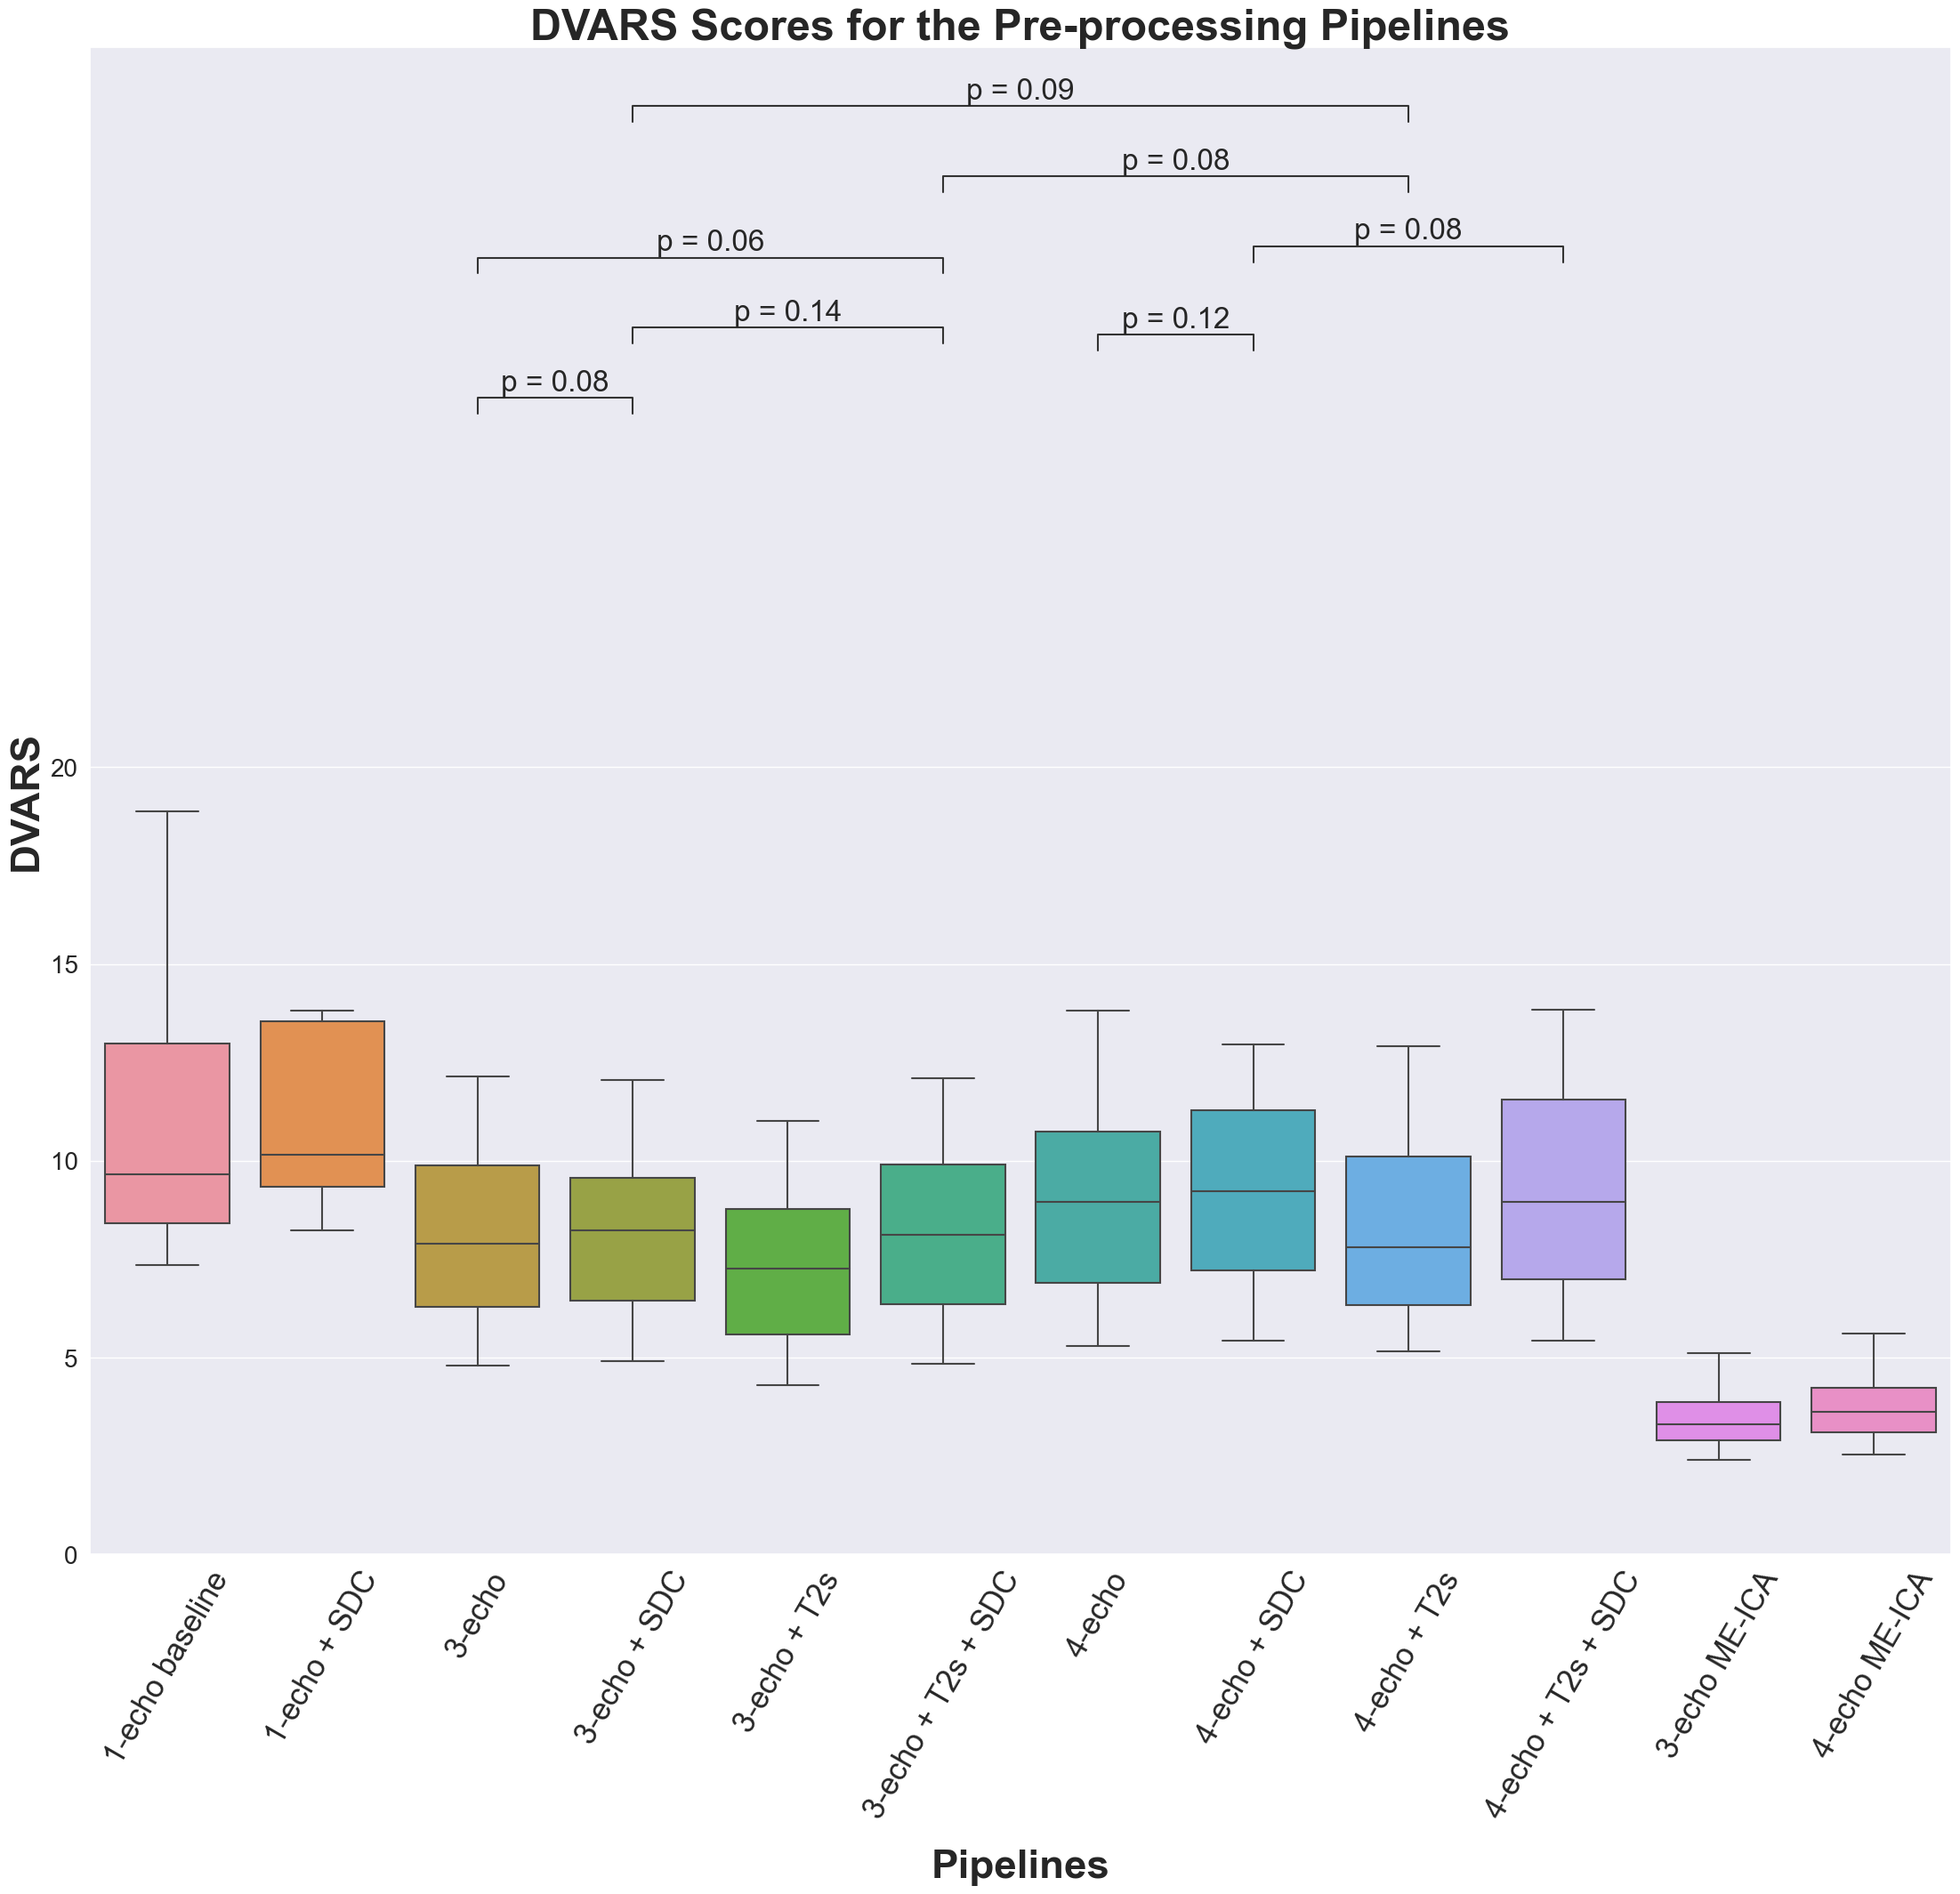

In [29]:
# Create a detailed DVARS boxplot
plt.rcParams["axes.labelsize"] = 33

# create the boxplot using seaborn instead of matplotlib
fig, ax = plt.subplots(figsize=(27,22))
sns.set(font_scale = 2)
ax.tick_params(axis='both', which='both', labelsize=15)

ax.xaxis.set_ticks([ind for ind in range(1, 13)])
ax.set_xticklabels(pipeline_names, rotation=60, fontsize=25)
ax.xaxis.labelpad = 20
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})

ax.yaxis.set_ticks([0, 5, 10, 15, 20])
ax.set_yticklabels(['0', '5', '10', '15', '20'], rotation=0, fontsize=20)
ax.set_ylim(ymax = 20)
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', 
             #facecolor='wheat', 
             alpha=0.5)

# place a text box in upper right in axes coords
#textstr = 'Most inter-pipeline differences are statistically significant'
#ax.text(0.35, 0.55, textstr, transform=ax.transAxes, fontsize=28,
#        verticalalignment='top', bbox=props)

sb_ax = sns.boxplot(data=pipeline_df, #corr_matrix_list, 
                    order=pipeline_names, 
                    showfliers=False).set(
    xlabel='Pipelines', 
    ylabel='DVARS'
)


# plot with annotations
test_results = add_stat_annotation(ax, data=pipeline_df, order=pipeline_names,
                                   box_pairs=[combo_list[i] for i in ns_list[0]],
                                   perform_stat_test=False, pvalues=[corrected_p_vals[i] for i in ns_list[0]],
                                   text_format='simple',
                                   loc='inside', 
                                   verbose=2)

ax.set_title('DVARS Scores for the Pre-processing Pipelines',fontsize= 35, fontweight="bold")

#plt.savefig("DVARS.png")